# **Этап 3.1: Построение моделей: Logistic Regression**

# **Шаг 1: Подготовка инструментов**

**1.1 Необходимые модули и функции**

In [1]:
import io
from sklearn.pipeline import Pipeline
import pandas as pd
import dill
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


**1.2 Загрузка пайплайна препроцессинга**


In [3]:
with open('../EDA_and_Preprocessing/prep_with_cat.dill', 'rb') as prep_cat_pipeline:
    prep_cat = dill.load(prep_cat_pipeline)

**1.3 Загрузка данных**

In [4]:
TRAIN_DATA_PATH = '../data/X_train.csv'
TRAIN_TARGET_PATH = '../data/y_train.csv'

TEST_DATA_PATH = '../data/X_test.csv'
TEST_TARGET_PATH = '../data/y_test.csv'

In [5]:
train_base = pd.read_csv(TRAIN_DATA_PATH)
train = train_base.copy()
train_target_base = pd.read_csv(TRAIN_TARGET_PATH)
train_target = train_target_base.copy()
display(train.shape, train_target.shape)

(641, 11)

(641, 1)

In [6]:
test_base = pd.read_csv(TEST_DATA_PATH)
test = test_base.copy()
test_target_base = pd.read_csv(TEST_TARGET_PATH)
test_target = test_target_base.copy()
display(test.shape, test_target.shape)

(276, 11)

(276, 1)

# **Шаг 2: Построение модели**

**2.1 Baseline**

Обучим модель с параметрами по умолчанию на тренировочной выборке.

In [7]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', LogisticRegression(random_state = 0)),
])

classifier.fit(train, train_target)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

In [8]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)
print(f'Train ROC_AUC: {roc_auc_score(train_target, train_pred_proba.T[1])}')
print(f'Train F1 SCORE: {f1_score(train_target, train_pred)}')
print(f'Test ROC_AUC: {roc_auc_score(test_target, test_pred_proba.T[1])}')
print(f'Test F1 SCORE: {f1_score(test_target, test_pred)}')

Train ROC_AUC: 0.9225870588003702
Train F1 SCORE: 0.8694444444444445
Test ROC_AUC: 0.9447367022689834
Test F1 SCORE: 0.8686868686868686


In [9]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       287
           1       0.86      0.88      0.87       354

    accuracy                           0.85       641
   macro avg       0.85      0.85      0.85       641
weighted avg       0.85      0.85      0.85       641

TEST

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       123
           1       0.90      0.84      0.87       153

    accuracy                           0.86       276
   macro avg       0.86      0.86      0.86       276
weighted avg       0.86      0.86      0.86       276



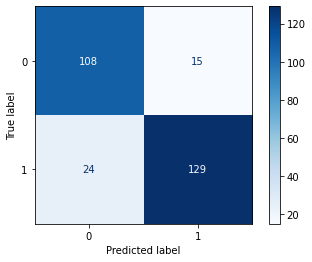

In [10]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues);

**2.2 Подбор гиперпараметров**

Гиперпараметры подбираем с помощью GridSearchCV с кроссвалидацией на 5 фолдов.

In [11]:
%%time
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

frozen_params = {
    'random_state': 0
}
parameters = {
    'C': np.logspace(-4, 4, 20), 
    'class_weight': [None, 'balanced'], 
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear'],
}

clf = GridSearchCV(LogisticRegression(**frozen_params), parameters, n_jobs=-1, verbose=3, scoring='f1' ,cv=cv)

classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', clf),
])
classifier.fit(train, train_target.values.ravel())

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 3/5] END C=0.0001, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.0001, class_weight=None, penalty=l2, solver=lbfgs;, score=0.714 total time=   0.0s
[CV 2/5] END C=0.0001, class_weight=None, penalty=l2, solver=liblinear;, score=0.821 total time=   0.0s
[CV 4/5] END C=0.0001, class_weight=None, penalty=l2, solver=liblinear;, score=0.817 total time=   0.0s
[CV 1/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=lbfgs;, score=0.832 total time=   0.0s
[CV 2/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=liblinear;, score=0.872 total time=   0.0s
[CV 3/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=liblinear;, score=0.857 total time=   0.0s
[CV 2/5] END C=0.00026366508987303583, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.00026366508987303583, class_weight=None, penalty=l1, solver=liblinear;, sc

[CV 1/5] END C=0.03359818286283781, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.806 total time=   0.0s[CV 4/5] END C=0.0001, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.0001, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=lbfgs;, score=0.869 total time=   0.0s
[CV 4/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=liblinear;, score=0.890 total time=   0.0s
[CV 5/5] END C=0.0001, class_weight=balanced, penalty=l2, solver=liblinear;, score=0.887 total time=   0.0s
[CV 4/5] END C=0.00026366508987303583, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.00026366508987303583, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 1/5] END C=0.00026366508987303583, class_weight=None, penalty=l2, solver=lbfgs;, score=0.710 total time=   0.0

[CV 1/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s[CV 1/5] END C=0.0001, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.0001, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 4/5] END C=0.0001, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.0001, class_weight=None, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.0001, class_weight=None, penalty=l2, solver=lbfgs;, score=0.707 total time=   0.0s
[CV 3/5] END C=0.0001, class_weight=None, penalty=l2, solver=lbfgs;, score=0.714 total time=   0.0s
[CV 1/5] END C=0.0001, class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.0001, class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.0001, class_weight=balanced, penalty=l1, solver=lbfgs;, sco

[CV 4/5] END C=0.08858667904100823, class_weight=None, penalty=l2, solver=liblinear;, score=0.859 total time=   0.0sCPU times: user 1.21 s, sys: 112 ms, total: 1.32 s
Wall time: 8.53 s


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

**2.3 Итоговая модель**

Обучим модель с лучшими параметрами на тренировочной выборке и посмотрим итоговое качество на тестовой выборке.

In [12]:
print(clf.best_score_)
print(clf.best_params_)

0.875424950374948
{'C': 0.004832930238571752, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


In [13]:
classifier = Pipeline([
    ('preprocessing', prep_cat),
    ('classifier', LogisticRegression(**clf.best_params_, random_state = 0)),
])
classifier.fit(train, train_target)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('minmax',
                                                                                    MinMaxScaler())]),
                                                                   ['Age',
                                                                    'RestingBP',
                                                                    'Cholesterol',
                                                                    'FastingBS',
                                                                    'MaxHR',
                                                                    'Oldpeak']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('ohe',
  

In [14]:
train_pred_proba = classifier.predict_proba(train)
train_pred = classifier.predict(train)
test_pred_proba = classifier.predict_proba(test)
test_pred = classifier.predict(test)

In [15]:
get_classification_report(train_target['HeartDisease'], train_pred, test_target['HeartDisease'], test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       287
           1       0.84      0.93      0.88       354

    accuracy                           0.86       641
   macro avg       0.87      0.85      0.86       641
weighted avg       0.86      0.86      0.86       641

TEST

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       123
           1       0.89      0.88      0.88       153

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.87      0.87      0.87       276



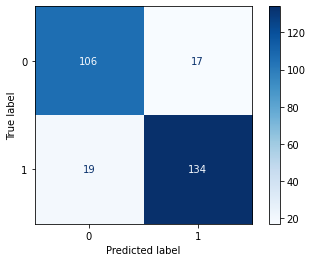

In [16]:
plot_confusion_matrix(classifier, test, test_target['HeartDisease'], cmap=plt.cm.Blues)


# **Шаг 3: Сохранение обученной модели**

In [17]:
with open("model_LogisticRegressionClassifier.dill", "wb") as f:
    dill.dump(classifier, f)


[CV 2/5] END C=0.03359818286283781, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.836 total time=   0.0s
[CV 3/5] END C=0.03359818286283781, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.781 total time=   0.0s
[CV 4/5] END C=0.03359818286283781, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.788 total time=   0.0s
[CV 5/5] END C=0.03359818286283781, class_weight=balanced, penalty=l1, solver=liblinear;, score=0.861 total time=   0.0s
[CV 1/5] END C=0.03359818286283781, class_weight=balanced, penalty=l2, solver=lbfgs;, score=0.835 total time=   0.0s
[CV 2/5] END C=0.03359818286283781, class_weight=balanced, penalty=l2, solver=lbfgs;, score=0.877 total time=   0.0s
[CV 1/5] END C=0.23357214690901212, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.23357214690901212, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.23357214690901212, class_weight=None, pena


[CV 2/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=liblinear;, score=0.841 total time=   0.0s
[CV 2/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=liblinear;, score=0.859 total time=   0.0s
[CV 3/5] END C=0.08858667904100823, class_weight=None, penalty=l1, solver=liblinear;, score=0.849 total time=   0.0s
[CV 2/5] END C=0.23357214690901212, class_weight=None, penalty=l2, solver=liblinear;, score=0.871 total time=   0.0s
[CV 3/5] END C=0.23357214690901212, class_weight=None, penalty=l2, solver=liblinear;, s